# Titanic Prediction (611 Final Project)
### Author: Myles Borthwick

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function Definitions

### 0.1 Classifier cross validation score

In [2]:
from sklearn.model_selection import cross_validate
def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    model.fit(X,y)
    
    ms_scores =  cross_validate(model, X, y, cv=cv, scoring = scoring, return_train_score = True)
    
    train_score = ms_scores['train_score'].mean()
    val_score = ms_scores['test_score'].mean()
    
    return(train_score, val_score)

### 0.2 Get grid search results

In [3]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    params = grid_search.best_params_
    scores = grid_search.cv_results_
    
    print("Best parameters: " , params)
    print("Mean training score: {:.3F}".format(scores['mean_train_score'].mean()))
    print("Mean test score: {:.3F}".format(scores['mean_test_score'].mean()))

### 0.3 Plot Grid Search Results on a Heatmap

In [4]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

### 0.4 Plot Confusion matrix to compare predicted and actual results

In [5]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    
    sns.heatmap(mat, square=True, annot=True, cbar=False, fmt = 'd')
    plt.xticks([0.5,1.5],labels=labels)
    plt.yticks([0.5,1.5],labels=labels)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title(title)

## 1.0 Load Data

In [6]:
train_df = pd. read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [7]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2.0 Analyzing Features

#### Lets take a look at how the categorical features relate to the target

### Gender

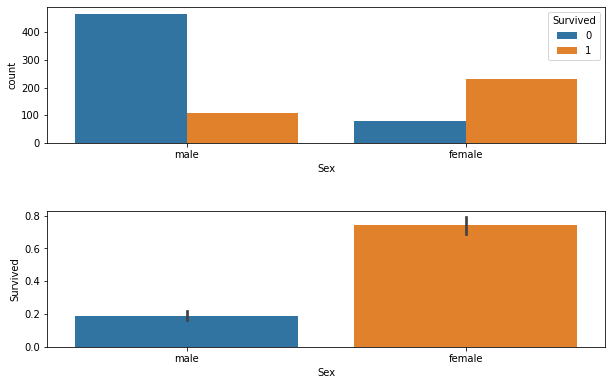

In [9]:

fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)


ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Sex', data=train_df, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Sex', data=train_df, y = 'Survived')


plt.show()

#### From the above graphs we can see that males where a lot less likely to survive

### Passenger Class

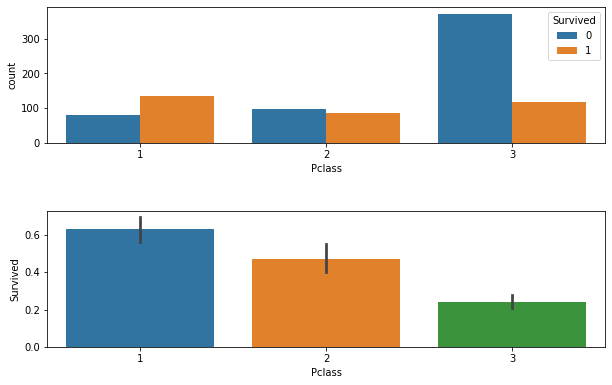

In [10]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Pclass', data=train_df, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Pclass', data=train_df, y = 'Survived')



#### The first class passengers had a higher chance of survival based on the above graphs

### Age

In [11]:
# Change nan values
train_df['Age'] = train_df['Age'].fillna(-0.5)
test_df['Age'] = test_df['Age'].fillna(-0.5)

#Create age groups to organize similar ages
bins = [-1, 0, 5, 12, 18, 60, np.inf]
labels = ['Unknown', 'Babies', 'Kids', 'Teens', 'Adult', 'Senior']

train_df['Age Group'] = pd.cut(train_df['Age'], bins, labels = labels)
test_df['Age Group'] = pd.cut(test_df['Age'], bins, labels = labels)



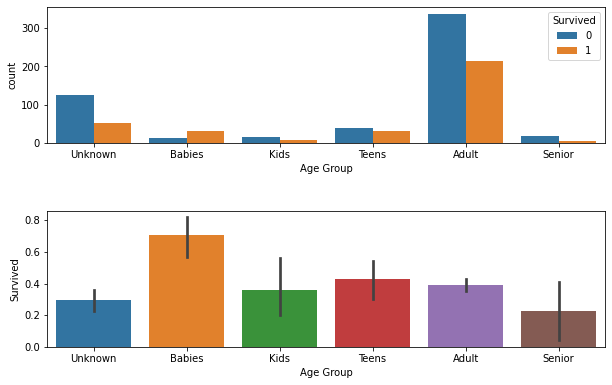

In [12]:

fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Age Group', data=train_df, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Age Group', data=train_df, y = 'Survived')

#### Babies had a high survival rate compared to theother age groups, however the majority of the passengers were adults as we will see later

### Siblings and Spouses

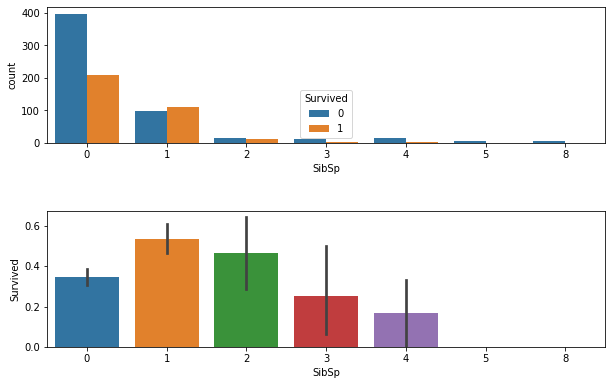

In [13]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='SibSp', data=train_df, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='SibSp', data=train_df, y = 'Survived')

#### It seems as though people either 1 or 2 siblings or 1 spouse also had a better chance of survival

### Parents and Children

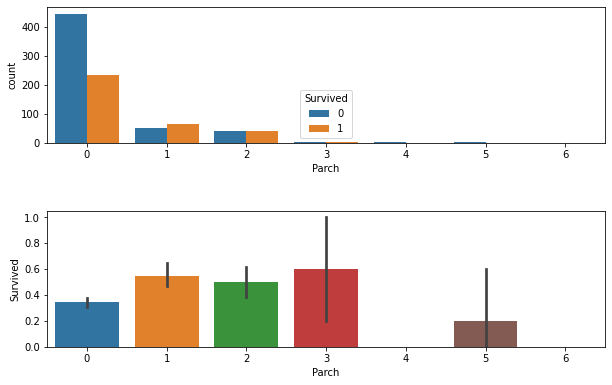

In [14]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Parch', data=train_df, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Parch', data=train_df, y = 'Survived')

## 3.0 Preprocessing

### 3.1 Remove Unnessesary Columns

In [15]:
train_df = train_df.drop(['Cabin'], axis = 1)
test_df = test_df.drop(['Cabin'], axis = 1)

train_df = train_df.drop(['Name'], axis = 1)
test_df = test_df.drop(['Name'], axis = 1)

train_df = train_df.drop(['Ticket'], axis = 1)
test_df = test_df.drop(['Ticket'], axis = 1)


In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age Group
0,1,0,3,male,22.0,1,0,7.2500,S,Adult
1,2,1,1,female,38.0,1,0,71.2833,C,Adult
2,3,1,3,female,26.0,0,0,7.9250,S,Adult
3,4,1,1,female,35.0,1,0,53.1000,S,Adult
4,5,0,3,male,35.0,0,0,8.0500,S,Adult


###  3.2 Fill NaN values

#### For age lets assume all unknown ages can be put into the adult group since it is a majority group

In [17]:
print("Number of adults:")
adult = train_df[train_df["Age Group"] == "Adult"].shape[0]
print(adult)

print("Number of kids:")
kids = train_df[train_df["Age Group"] == "Kids"].shape[0]
print(kids)

print("Number of teens:")
teens = train_df[train_df["Age Group"] == "Teens"].shape[0]
print(teens)

print("Number of babies:")
babies = train_df[train_df["Age Group"] == "Babies"].shape[0]
print(babies)

print("Number of seniors:")
seniors = train_df[train_df["Age Group"] == "Senior"].shape[0]
print(seniors)




Number of adults:
553
Number of kids:
25
Number of teens:
70
Number of babies:
44
Number of seniors:
22


In [18]:
# Replace unknown with adult
train_df = train_df.replace('Unknown', 'Adult')
test_df = test_df.replace('Unknown', 'Adult')


### 3.3 Mapping features to numerical values

#### Map age group to a numerical value

In [19]:
age_map = {'Babies': 1, 'Kids': 2, 'Teens': 3, 'Adult': 4, 'Senior': 5}

train_df['Age Group'] = train_df['Age Group'].map(age_map)
test_df['Age Group'] = test_df['Age Group'].map(age_map)



In [20]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age Group
0,1,0,3,male,22.0,1,0,7.2500,S,4.0
1,2,1,1,female,38.0,1,0,71.2833,C,4.0
2,3,1,3,female,26.0,0,0,7.9250,S,4.0
3,4,1,1,female,35.0,1,0,53.1000,S,4.0
4,5,0,3,male,35.0,0,0,8.0500,S,4.0


In [21]:
#Drop age column
train_df = train_df.drop(['Age'], axis = 1)
test_df = test_df.drop(['Age'], axis = 1)

In [22]:
# Change values to int in age group column
train_df['Age Group'] = train_df['Age Group'].astype(int)
test_df['Age Group'] = test_df['Age Group'].astype(int)


In [23]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group
0,1,0,3,male,1,0,7.2500,S,4
1,2,1,1,female,1,0,71.2833,C,4
2,3,1,3,female,0,0,7.9250,S,4
3,4,1,1,female,1,0,53.1000,S,4
4,5,0,3,male,0,0,8.0500,S,4


#### For embark, we can do the same thing as with age


In [24]:
print("Number Embarking from S:")
S = train_df[train_df["Embarked"] == "S"].shape[0]
print(S)

print("Number Embarking from C:")
C = train_df[train_df["Embarked"] == "C"].shape[0]
print(C)

print("Number Embarking from Q:")
Q = train_df[train_df["Embarked"] == "Q"].shape[0]
print(Q)

Number Embarking from S:
644
Number Embarking from C:
168
Number Embarking from Q:
77


In [25]:
#Replace nan values with majority S
train_df = train_df.fillna({'Embarked':'S'})

In [26]:
embarked_map = {"S": 1, "C": 2, "Q": 3}
train_df['Embarked'] = train_df['Embarked'].map(embarked_map)
test_df['Embarked'] = test_df['Embarked'].map(embarked_map)

train_df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group
0,1,0,3,male,1,0,7.2500,1,4
1,2,1,1,female,1,0,71.2833,2,4
2,3,1,3,female,0,0,7.9250,1,4
3,4,1,1,female,1,0,53.1000,1,4
4,5,0,3,male,0,0,8.0500,1,4


#### Map Sex to numerical value

In [27]:

sex_map = {"male": 0, "female": 1}
train_df['Sex'] = train_df['Sex'].map(sex_map)
test_df['Sex'] = test_df['Sex'].map(sex_map)

train_df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group
0,1,0,3,0,1,0,7.2500,1,4
1,2,1,1,1,1,0,71.2833,2,4
2,3,1,3,1,0,0,7.9250,1,4
3,4,1,1,1,1,0,53.1000,1,4
4,5,0,3,0,0,0,8.0500,1,4


#### Map the fare feature to numerical values

In [28]:
test_df = test_df.dropna(subset=['Fare'])

In [29]:
train_df['Fare Range'] = pd.qcut(train_df['Fare'], 4, labels = [1, 2, 3, 4])
test_df['Fare Range'] = pd.qcut(test_df['Fare'], 4, labels = [1, 2, 3, 4])
test_df['Fare Range'] = test_df['Fare Range'].dropna()

In [30]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group,Fare Range
0,1,0,3,0,1,0,7.2500,1,4,1
1,2,1,1,1,1,0,71.2833,2,4,4
2,3,1,3,1,0,0,7.9250,1,4,2
3,4,1,1,1,1,0,53.1000,1,4,4
4,5,0,3,0,0,0,8.0500,1,4,2


In [31]:
train_df = train_df.drop(['Fare'], axis = 1)
test_df = test_df.drop(['Fare'], axis = 1)

## 4.0 Resulting Dataframes

#### We now have 'clean' dataframes to work with that do not include null values and are all of numerical value

In [32]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Range
0,1,0,3,0,1,0,1,4,1
1,2,1,1,1,1,0,2,4,4
2,3,1,3,1,0,0,1,4,2
3,4,1,1,1,1,0,1,4,4
4,5,0,3,0,0,0,1,4,2


In [33]:
test_df.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Range
0,892,3,0,0,0,3,4,1
1,893,3,1,1,0,1,4,1
2,894,2,0,0,0,3,5,2
3,895,3,0,0,0,1,4,2
4,896,3,1,1,1,1,4,2


# 5.0 Applying ML Models

### 5.1 Split Training Data into features and target

In [34]:

X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df["Survived"]


In [35]:
print("X shape = ", X.shape, ", X type = ", type(X), "\n")
print("y shape = ", y.shape,", y type = ", type(y), "\n")


X shape =  (891, 7) , X type =  <class 'pandas.core.frame.DataFrame'> 

y shape =  (891,) , y type =  <class 'pandas.core.series.Series'> 



### 5.2 Check Imbalance

In [36]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Data is not considered imbalanced since there is less than a 2:1 comparitive difference

### 5.3 Encoding features

In [37]:
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(sparse=False)
enc.fit(X)

X_enc = enc.transform(X)


print("Shape of encoded X is: " , X_enc.shape)

Shape of encoded X is:  (891, 31)


#### Transform target column to array

In [38]:
y = y.to_numpy()

### 5.4 Split the data into validation and train sets

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_enc, y, test_size = 0.2)

### 5.5 Set Up Models and Get Scores for each

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


model_log = LogisticRegression()
model_forest = RandomForestClassifier(random_state=55)
model_gb = GradientBoostingClassifier(random_state=56)
model_svc = SVC()
model_nb = GaussianNB()

models = [model_forest, model_gb,  model_svc, model_nb, model_log]
model_names = ["RandomForestClassifier", "GradientBoostingClassifier","SVC", "GaussianNB", "LogisticRegression"]

In [41]:
print('Average precision for each model ranked best to last:\n')
n = 0
for i in models:
    print(model_names[n])
    cv_scores = get_classifier_cv_score(i, X_train, y_train, scoring = 'average_precision')
    print('Training score = {:.3f}'.format(cv_scores[0]))
    print('Validation score = {:.3f}\n'.format(cv_scores[1]))
    n+=1

Average precision for each model ranked best to last:

RandomForestClassifier
Training score = 0.939
Validation score = 0.844

GradientBoostingClassifier
Training score = 0.909
Validation score = 0.847

SVC
Training score = 0.868
Validation score = 0.828

GaussianNB
Training score = 0.655
Validation score = 0.645

LogisticRegression
Training score = 0.842
Validation score = 0.828



#### From the above results we can see that RandomForest, GradientBoostingClassifier and SVC show promising performance scores with a close runner up being LogisticRegression

## 6.0 Hyperparameter tuning with GridsearchCV

We will now apply GridSearchCV with 7-fold crossvalidation to tune our best models

### 6.1 Grid Search For Random Forest

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid_forest = {'n_estimators': [300, 500, 700, 1000],
                    'max_depth': [7, 9, 11, 13]}

grid_forest = GridSearchCV(model_forest, param_grid_forest, scoring = 'average_precision', cv=7, n_jobs = 4, return_train_score=True)

In [43]:
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='average_precision')

In [44]:
print_grid_search_result(grid_forest)

Best parameters:  {'max_depth': 7, 'n_estimators': 300}
Mean training score: 0.932
Mean test score: 0.852


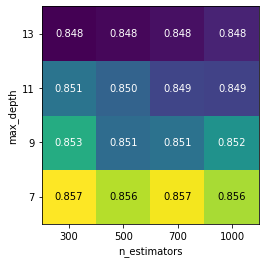

In [45]:
plot_grid_search_results(grid_forest)

### 6.2 Grid Search for Gradient Boosting Classifier

In [46]:
model_gb = GradientBoostingClassifier(max_depth = 5, random_state=56)

param_grid_gb = {'n_estimators': [50, 100, 200],
                    'learning_rate': [0.001, 0.01, 0.1, 1.0]}

grid_gb = GridSearchCV(model_gb, param_grid_gb, scoring = 'average_precision', cv=7, n_jobs = 4, return_train_score=True)

In [47]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [48]:
print_grid_search_result(grid_gb)

Best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
Mean training score: 0.919
Mean test score: 0.809


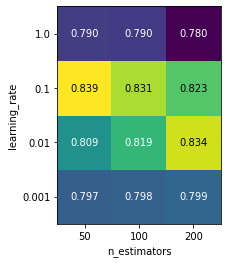

In [49]:
plot_grid_search_results(grid_gb)

### 6.3 Grid Search for SVC

In [50]:
param_grid_svc = {'C': [0.0001, 0.001, 0.01, 0.1],
                    'gamma': [0.1, 1, 10, 100]}

grid_svc = GridSearchCV(model_svc, param_grid_svc, scoring = 'average_precision', cv=7, n_jobs = 4, return_train_score=True)

In [51]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [52]:
print_grid_search_result(grid_svc)

Best parameters:  {'C': 0.1, 'gamma': 0.1}
Mean training score: 0.861
Mean test score: 0.798


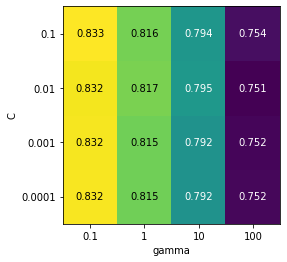

In [53]:
plot_grid_search_results(grid_svc)

## 7.0 Model Comparison

The following scores for the three tuned models were:

1.RandomForestClassifier 

    Mean training score: 0.931
    Mean test score: 0.851

2.GradientBoostingClassifier

    Mean training score: 0.915
    Mean test score: 0.826

3.SVC

    Mean training score: 0.857
    Mean test score: 0.797
    
While all models perform well, we will use RandomForestClassifier as our Best Model. THese values may slightly change on subsequent runs as they are mean averages taken at one runtime.

## 8.0 Finding a Better Threshold For High Recall

In [54]:
from sklearn.model_selection import cross_val_predict

model_forest = grid_forest.best_estimator_


y_pred_proba = cross_val_predict(model_forest, X_train, y_train, cv=7, method = 'predict_proba')
print(y_pred_proba)

[[0.83107502 0.16892498]
 [0.42517103 0.57482897]
 [0.89351233 0.10648767]
 ...
 [0.90815707 0.09184293]
 [0.05355376 0.94644624]
 [0.51643815 0.48356185]]


### 8.1 Precision and Recall Curve

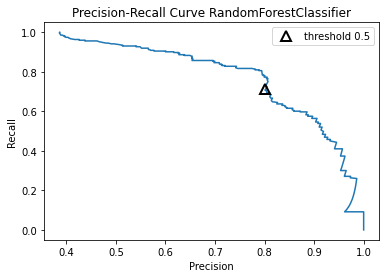

In [55]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba[:, 1])

plt.plot(precision, recall)
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k',
         markersize=10, label="threshold 0.5", fillstyle="none", mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend()
plt.title("Precision-Recall Curve RandomForestClassifier")

plt.show()

### 8.2 Find a better threshold

#### Although it is not so important to find a better threshold for this project as the use for these predicitons is purely hypothetical. It may still be interesting to tune the model so it does not throw false survival predictions and isnt as concerned with false death predictions 

In [56]:
desired_recall = 0.999
idx = np.argwhere(recall > desired_recall)[-1][0]
th = thresholds[idx]
print("New Threshold is: ",th)

New Threshold is:  0.06586257814419187


## 9.0 Predicting with Training Data

### 9.1 Retraining best model

In [57]:
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, random_state=55)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_val, model_forest.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       110
           1       0.67      0.67      0.67        69

    accuracy                           0.74       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.74      0.74      0.74       179



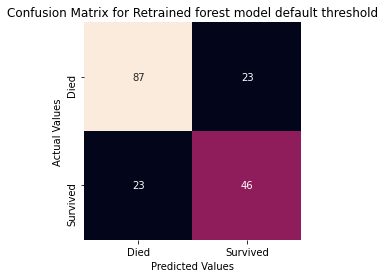

In [59]:
plot_confusion_matrix(y_val, model_forest.predict(X_val), ['Died', 'Survived'], title = 'Confusion Matrix for Retrained forest model default threshold')

### 9.2 Retrain model with new threshold

In [60]:
y_prob = model_forest.predict_proba(X_val)

my_prediction = np.where(y_prob[:,0] > th, 0, 1)

print(classification_report(y_val, my_prediction ))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       110
           1       1.00      0.13      0.23        69

    accuracy                           0.66       179
   macro avg       0.82      0.57      0.51       179
weighted avg       0.78      0.66      0.57       179



In [61]:
print(X_val.shape)

(179, 31)


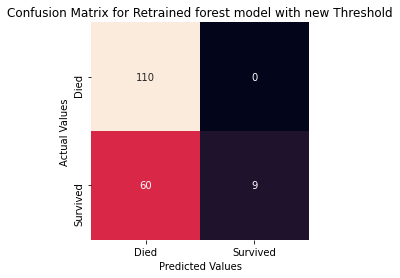

In [62]:
plot_confusion_matrix(y_val, my_prediction, ['Died', 'Survived'], title = 'Confusion Matrix for Retrained forest model with new Threshold')

#### Here we can see the re-trained model with a new threshold does not throw false survival predictions but it throws more false death predictions

## 10.0 Using my Best Model to Predict on the test.csv Set

### 10.1 Quick Processing of test.csv to work with model

#### The original dataset has a different number of features after being encoded when compared to the encoded test set. Upon inspection this is because the max in the Parch Column is higher than the max from the training set

In [63]:
test_df['Parch'].describe()

count    417.000000
mean       0.393285
std        0.982419
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        9.000000
Name: Parch, dtype: float64

In [64]:
train_df['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

#### To fix this we can filter out the rows where the parch value is greater than our training set (6), in this case its only 2 rows

In [65]:
test_df = test_df[test_df['Parch'] <= 6]
ids = test_df['PassengerId']
test_df = test_df.drop('PassengerId', axis = 1)
test_df.shape

(415, 7)

In [66]:
X_test = test_df
enc = OneHotEncoder(sparse=False)
enc.fit(X_test)

X_enc = enc.transform(X_test)


print("Shape of encoded X_test is: " , X_enc.shape)

Shape of encoded X_test is:  (415, 31)


In [67]:
X_test = test_df

### Now we should have the same feature size and can use the tuned model to predict

### 10.2 Encoding test features

In [68]:
enc = OneHotEncoder(sparse=False)
enc.fit(X_test)

X_test_enc = enc.transform(X_test)


print("Shape of encoded X_test is: " , X_test_enc.shape)

Shape of encoded X_test is:  (415, 31)


### 10.3 Final Prediction for test.csv Data (Using Re-trained model with Default Threshold)

In [69]:
myPrediction = model_forest.predict(X_test_enc)

In [70]:
X_test.head()

,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Range
0,3,0,0,0,3,4,1
1,3,1,1,0,1,4,1
2,2,0,0,0,3,5,2
3,3,0,0,0,1,4,2
4,3,1,1,1,1,4,2


In [71]:
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': myPrediction, 'Pclass' : X_test['Pclass'], 
                       'Sex' : X_test['Sex'], 'SibSp' : X_test['SibSp'], 'Parch' : X_test['Parch'],
                       'Embarked' : X_test['Embarked'], 'Age Group' : X_test['Age Group'], 'Fare Range' : X_test['Fare Range']})
output_sub = pd.DataFrame({ 'PassengerId' : ids, 'Survived': myPrediction})
output_sub.to_csv('submission.csv', index=False)

### 10.4 Analysing Predictions

In [72]:
output.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Range
0,892,0,3,0,0,0,3,4,1
1,893,1,3,1,1,0,1,4,1
2,894,0,2,0,0,0,3,5,2
3,895,0,3,0,0,0,1,4,2
4,896,0,3,1,1,1,1,4,2


#### 10.4.1 Distribution

<AxesSubplot:xlabel='Survived', ylabel='count'>

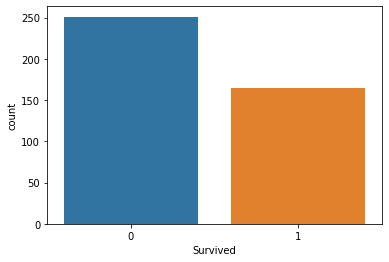

In [73]:
sns.countplot(x='Survived', data=output)

#### 10.4.2 Sex (0=Male, 1=Female)

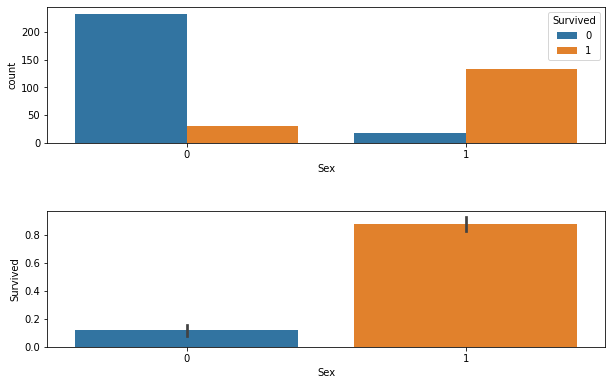

In [74]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)


ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Sex', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Sex', data=output, y = 'Survived')


plt.show()

#### 10.4.3 Passenger Class

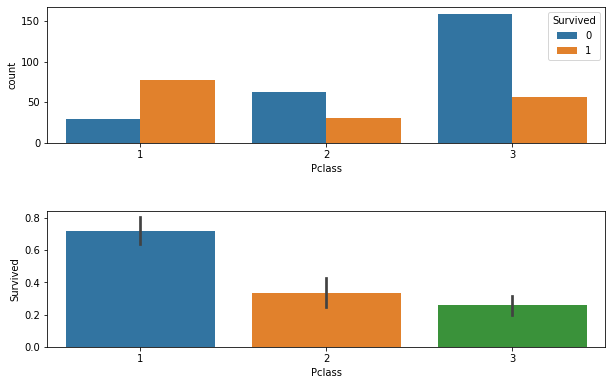

In [75]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Pclass', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Pclass', data=output, y = 'Survived')

#### 10.4.4 Age Group (Baby:1, Kid:2, Teen:3, Adult:4, Senior:5)

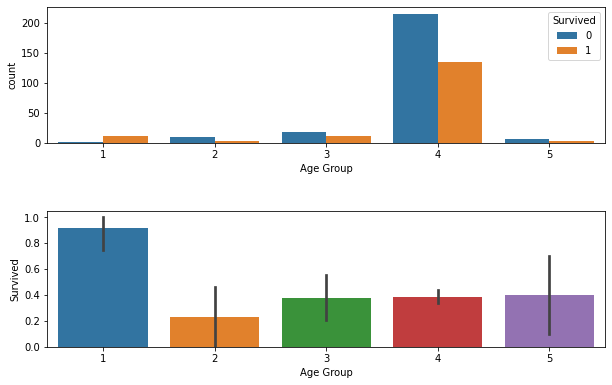

In [76]:

fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Age Group', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Age Group', data=output, y = 'Survived')

#### 10.4.5 Siblings and Spouses


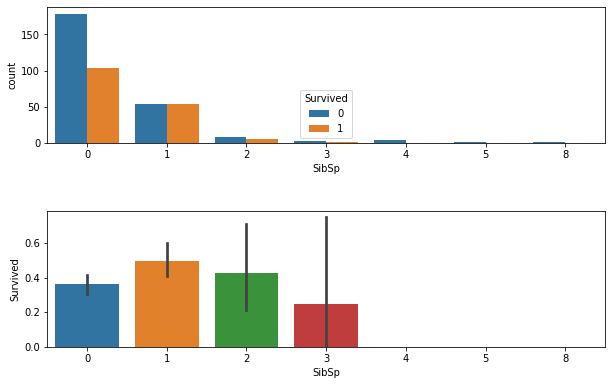

In [77]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='SibSp', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='SibSp', data=output, y = 'Survived')

#### 10.4.6 Parents and Children

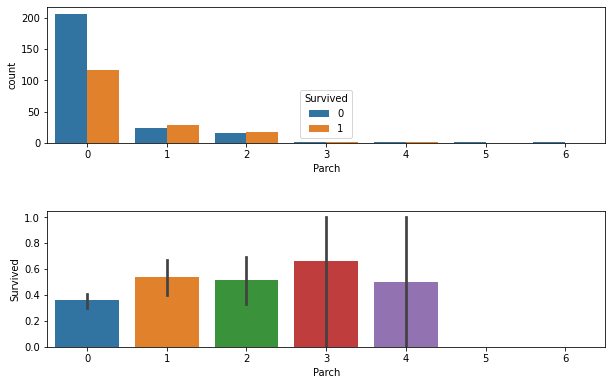

In [78]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Parch', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Parch', data=output, y = 'Survived')

#### 10.4.7 Fare Range

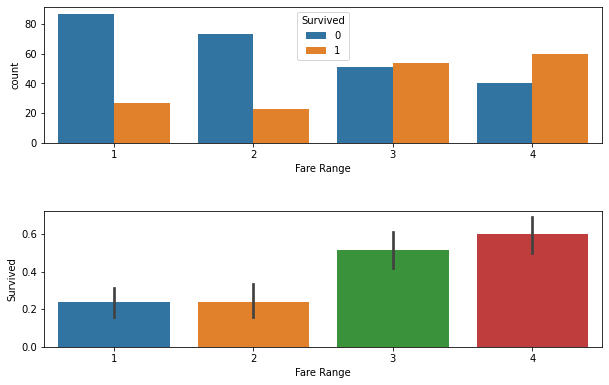

In [79]:
fig = plt.figure(figsize=(10,10))

fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(311)
ax1 = sns.countplot(x='Fare Range', data=output, hue = 'Survived')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='Fare Range', data=output, y = 'Survived')

### The above graphs show the same trends as explored earlier in the test set features

### Thanks for reading!